# "War and Peace" text analysis

By [Ben Welsh](http://palewi.re/who-is-ben-welsh/)

In [43]:
import re
import nltk
import string
import collections
import altair as alt
import pandas as pd
from nltk import word_tokenize

In [33]:
alt.themes.enable('opaque')
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/palewire/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Download it.

In [1]:
!wget http://www.gutenberg.org/files/2600/2600-0.txt

--2018-08-05 15:02:35--  http://www.gutenberg.org/files/2600/2600-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 2610:28:3090:3000:0:bad:cafe:47, 152.19.134.47
Connecting to www.gutenberg.org (www.gutenberg.org)|2610:28:3090:3000:0:bad:cafe:47|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3359542 (3.2M) [text/plain]
Saving to: ‘2600-0.txt’

2600-0.txt          100%[===================>]   3.20M  1.26MB/s    in 2.5s    

2018-08-05 15:02:38 (1.26 MB/s) - ‘2600-0.txt’ saved [3359542/3359542]



In [2]:
!mv 2600-0.txt war-and-peace.txt

Split it up.

In [3]:
full_text =  open("war-and-peace.txt", "r").read()

In [4]:
start = re.compile("\*\*\* START OF THIS PROJECT(.*)\*\*\*")

In [5]:
end = re.compile("\*\*\* END OF THIS PROJECT(.*)\*\*\*")

In [6]:
book = end.split(start.split(full_text)[2])[0]

In [7]:
toc = book.split("BOOK ONE: 1805", 2)[:2]

In [8]:
body = "BOOK ONE: 1805\n" + book.split("BOOK ONE: 1805", 2)[2]

Parse the books

In [9]:
book_hed = re.compile("^BOOK (.*)$")

In [10]:
epi_hed = re.compile("^(.*)EPILOGUE(.*)$")

In [11]:
book_dict = collections.OrderedDict()

In [44]:
current_book = ""
for line in body.split("\n"):
    if book_hed.search(line):
        current_book = line
    elif epi_hed.search(line):
        current_book = line
    if not line.strip():
        continue
    try:
        book_dict[current_book] += line + "\n"
    except KeyError:
        book_dict[current_book] = line + "\n"

Load into pandas

In [55]:
df = pd.DataFrame.from_dict(book_dict, orient="index").reset_index().rename(columns={"index": "book", 0: "text"})

In [56]:
df['number'] = df.book.apply(lambda x: x.split(":")[0].strip())

In [57]:
df['order'] = df.index

Character counts

In [58]:
df['length'] = df.text.apply(lambda x: len(x))

In [87]:
df['split'] = df.text.apply(lambda x: len(x.split()))

In [67]:
df['tokens'] = df.text.apply(lambda x: len(word_tokenize(x)))

In [68]:
punctuation = re.compile('[%s]' % re.escape(string.punctuation)) 

In [79]:
def real_tokenize(text):
    tokens = word_tokenize(text)
    return len([t for t in tokens if punctuation.sub('', t) != ''])

In [80]:
df['real_tokens'] = df.text.apply(real_tokenize)

In [85]:
df.real_tokens.sum()

1189164

Chart

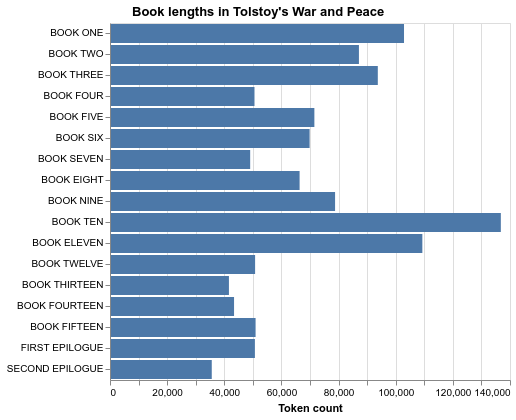

In [89]:
alt.Chart(df, title="Book lengths in Tolstoy's War and Peace").mark_bar().encode(
    x=alt.X(
        "real_tokens:Q",
        axis=alt.Axis(title="Token count")
    ),
    y=alt.Y(
        "number:N",
        axis=alt.Axis(title=""),
        sort=alt.SortField(field="order", op="sum", order="ascending")
    )
)